# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set()

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm # Note the short form
import statsmodels.formula.api as smf # Note the short form

%matplotlib inline


### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
# Open Advertising CSV to take a look at what the data looks like
# Observe that first column is redundant
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
# Check that it is read correctly
advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
# repeat for Credit.csv
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [5]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

Text(0.5, 1.0, 'Sales regression on TV')

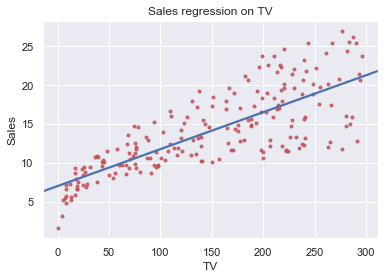

In [6]:
sns.set_style('darkgrid')
sns.regplot(advertising['TV'],
            advertising['Sales'],
            order=1,
            ci=None,
            scatter_kws={
                'color': 'r',
                's': 9
            })
plt.title('Sales regression on TV')

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

#### Obtain B0 and B1 values

In [7]:
advertising['Sales'].shape

(200,)

In [8]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

# Getting it to the same form as the one in the textbook
# with_std = False gets it to scale back to non-normalized variance
# Reshape(-1,1) -1 simply means that it is an unknown dimension and we want numpy to figure it out
# we just specify that we want 1 column
X = scale(advertising['TV'], with_mean=True, with_std=False).reshape(-1,1)
y = advertising['Sales']
# Note that we are working with column vectors of (n,1) for X
# Note that we are working with (n,) for y
print(X.shape,y.shape,sep='\t')

regr.fit(X,y)
print('intercept: ' + str(regr.intercept_)) # sk_learn variable name holding B0
print('gradient: ' + str(regr.coef_)) # sk_learn variable name holding B1

(200, 1)	(200,)
intercept: 14.0225
gradient: [0.04753664]


#### Set-up values needed for 3-D plot, RSS = f(B0,B1)

In [9]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50) # vary B0 from best fit
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50) # vary B1 from best fit
B0_grid, B1_grid = np.meshgrid(B0, B1, indexing='xy') # Create grid of B0/B1
# Create grid of points (think of it as generating surface and we have to vary z axis now)
Z = np.zeros((B0.size,B1.size))  # Z = RSS = Residual
# Create empty array to fill B0_hat, B1_hat (see textbook notation - minimizers)

for (i,j),v in np.ndenumerate(Z):
#     Return an iterator yielding pairs of array index (i,j) and values.
#     Formula to calculate RSS: 
#     residual, ei = Yi - (B0 + B1X) = y - (xx[i,j]+X.ravel()*yy[i,j])
#     RSS = sum(ei**2)
    Z[i,j] = np.sum((y - (B0_grid[i,j]+X.ravel()*B1_grid[i,j]))**2)/1000 
    # Original line, divide by 1000 for the plot to work (otherwise too small)

#     X shape = (200,1) X.ravel shape = (200,1)
print('Z shape' + str(Z.shape))
# Minimized RSS
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
# divide by 1000 for consistency - as long as it is on the same scale it doesnt matter

print('Min RSS= ' + str(min_rss))

Z shape(50, 50)
Min RSS= 2.1025305831313514


##### Side-exploration of np.meshgrid/np.ndenumerate/np.unravel

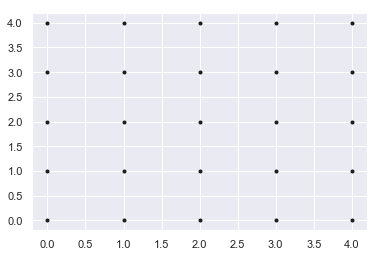

In [10]:
# The purpose of meshgrid is to create a rectangular grid out of an array of 
# x values and an array of y values
xvalues = np.array([0, 1, 2, 3, 4]);
yvalues = np.array([0, 1, 2, 3, 4]);
xx_values, yy_values = np.meshgrid(xvalues, yvalues)
plt.plot(xx_values, yy_values, marker='.', color='k', linestyle='none')


In [11]:
# Return an iterator yielding pairs of array coordinates and values.
# Crucial to understand that it returns 2 parameters (index + value)
# Need to specify i,j to loop over ndenumerate
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
for index, values in np.ndenumerate(A):
    print(index, values)  # operate here

(0, 0) 1
(0, 1) 2
(0, 2) 3
(1, 0) 4
(1, 1) 5
(1, 2) 6
(2, 0) 7
(2, 1) 8
(2, 2) 9


In [12]:
# Return a contiguous flattened array.
x = np.array([[1, 2, 3], [4, 5, 6]])
np.ravel(x).shape

(6,)

#### Actual plot

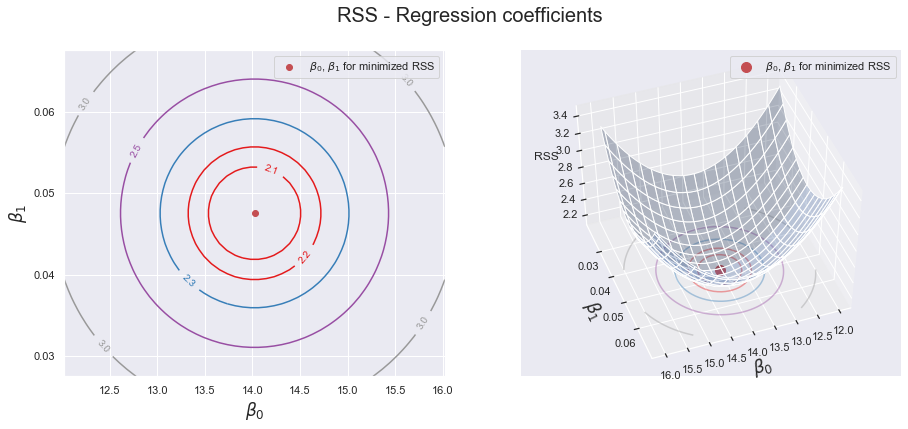

In [13]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,6)) # Initialize figure 
fig.suptitle('RSS - Regression coefficients', fontsize=20) # Add a centered title to the figure

# We want to create 2 views of the 3-D plot, one contour and one surface plot
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122, projection='3d') # note the additional parameter, initialize 3-D axes

# Left plot - contour plot
CS = ax1.contour(B0_grid, B1_grid, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3]) 
# levels = Determines the number and positions of the contour lines / regions
# cmap to preset colors

# Left plot
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS' # to be inserted in label below
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS) # plot best value of B0,B1
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f') # adds values to each contour level

# Right plot
# Initialize surface plot
ax2.plot_surface(B0_grid, B1_grid, Z, rstride=3, cstride=3, alpha=0.3)

# Add contour lines on x-y plane in 3D system (same plot as left plot)
ax2.contour(B0_grid, B1_grid, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])

ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', s=100, label=min_RSS) 
# Problem with this, not showing up on plot

ax2.set_zlabel('RSS') # z label
ax2.set_zlim(Z.min(),Z.max()) # Necessary to set the bottom of the graph to best Z
ax2.set_ylim(0.02,0.07)
ax2.view_init(50, 70)
# we’ll use an elevation of x degrees above the x-y plane and rotated y degrees counter-clockwise 
# about the z-axis

# settings common axes labels to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
#     Have to do this to match B1 on both plots for clarity of comparison
#     Otherwise, left plot will have more ticks than right plot
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [14]:
# Fit regression model (using the natural log of one of the regressors == ols) 
estimates = smf.ols('Sales ~ TV', advertising).fit()
# Note the notation - only fits Y~xi

for i in range(3):
    print(estimates.summary().tables[i])

# estimates.summary() returns 3 tables [0,1,2]
# To specify specific table we are interested in:
# estimates.summary().tables[1]

# Table 2:
# for the regression of sales on TV advertising budget. 
# An increase of $1,000 in the TV advertising budget is associated with an increase in sales by
# around 48 units (Recall that the sales variable is in thousands of units, and the
# TV variable is in thousands of dollars).

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           1.47e-42
Time:                        22:02:04   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

#### Hypothesis testing

t-statistic (t) is computed from standard errors of B0_hat and B1_hat respectively.

\begin{equation}\label{eq:}
t = \frac{\boldsymbol{\hat{B_1}} - 0}{SE(\boldsymbol{\hat{B_1}})}
\end{equation}

t-statistic is used as the p-value against which alpha is measured against in hypothesis testing

The coefficients for $β_0$ and $β_1$ (coef) are very large relative to their standard errors (std err), so the t-statistics (t) are also large; the probabilities of seeing such values (P>|t|) if H0 is true are virtually zero. Hence we can conclude that $β_0$!=0 and $β_1$!=0.

#### Asessing accuracy of model

1. R^2 statistic - as close to 1 as possible
2. RSE - minimize value

#### RSS with regression coefficients

In [15]:
# RSS = residual squared sum
# RSS = sum(ei**2)
# ei = Y - (B0 + B1X)
# Defined on /1000 scale
((advertising['Sales'] - (estimates.params[0] + estimates.params[1]*advertising['TV']))**2).sum()/1000

2.1025305831313514

### Table 3.1 & 3.2 - Scikit-learn

In [16]:
regr = skl_lm.LinearRegression()

X = advertising['TV'].values.reshape(-1,1) # Need to nclude .values for .reshape to work
y = advertising['Sales']
# Note that we are working with column vectors of (n,1) for X
# Note that we are working with (n,) for y
print(X.shape, y.shape, sep='\t')

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

(200, 1)	(200,)
7.032593549127693
[0.04753664]


In [17]:
y_fit = regr.predict(X)
r2_score(y, y_fit)

0.611875050850071

## 3.2 Multiple Linear Regression

When we perform multiple linear regression, we usually are interested in
answering a few important questions.

1. Is at least one of the predictors X1,X2, . . . , Xp useful in predicting
the response?
2. Do all the predictors help to explain Y , or is only a subset of the
predictors useful?
3. How well does the model fit the data?
4. Given a set of predictor values, what response value should we predict,
and how accurate is our prediction?

### Multiple simple linear regression models

#### Table 3.3 - Sales on Radio & Sales on Newspaper

In [18]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [23]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


### Multiple regression model

### Table 3.4 & 3.6 - Statsmodels

**Interpretation of results**
- For a given amount of TV and newspaper advertising, spending an additional $1,000 on radio advertising leads to an increase in sales by approximately 189 units.

- However, while the newspaper regression coefficient estimate in Table 3.3 was significantly non-zero, the coefficient estimate for newspaper in the multiple regression model is close to zero, and the corresponding p-value is no longer significant, with a value around 0.86.

**Explain the difference between simple regression and multiple regression model**
- In the simple regression case, the slope term represents the average effect of a $1,000 increase in newspaper advertising, ignoring other predictors such as TV and radio. 

- In the multiple regression setting, the coefficient for newspaper represents the average effect of increasing newspaper spending by $1,000 while holding TV and radio fixed.

**Individual P-values for each predictor vs. Overall F-statistic**

It seems likely that if any one of the p-values for the individual variables is very small, then at least one of the predictors is related to the response. However, this logic is flawed, especially
when the number of predictors p is large.

For instance, consider an example in which p = 100 and H0 : β1 = β2 = . . . = βp = 0 is true, so no variable is truly associated with the response. In this situation, about 5% of the p-values associated with each variable will be below 0.05 by chance. In other words, we expect to see approximately five small p-values even in the absence of any true association between the predictors and the response. we are almost guaranteed that we will observe at least one p-value below 0.05 by chance!

Hence, if we use the individual t-statistics and associated pvalues in order to decide whether or not there is any association between the variables and the response, there is a very high chance that we will incorrectly conclude that there is a relationship. However, the F-statistic does not suffer from this problem because it adjusts for the number of predictors.

**Notes on using the F-statistic**

The approach of using an F-statistic to test for any association between the predictors and the response works when p is relatively small, and certainly small compared to n

In [22]:
estimates = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit() # Note the notation
for i in range(1,2): # Change the range to see other tables
    print(estimates.summary().tables[i])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011


### Table 3.5 - Correlation Matrix

In [23]:
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


### F-statistics
**Significance of F-statistic**
- No relationship between response and predictor --> F-stat = 1
- Relationship between response and predictor --> F-stat > 1

Look at [2,2] for F-Statistic = 570. Since this is far larger than 1, it provides compelling evidence against the null hypothesis H0. This suggests that at least one of the advertising media must be related to sales

**How large does F-statistic need to be?**
When n is large, an F-statistic that is just a little larger than 1 might still provide evidence against H0. In contrast, a larger F-statistic is needed to reject H0 if n is small.

For the advertising data, the p-value associated with the F-statistic is essentially zero, so we have extremely strong evidence that at least one of the media is associated with increased sales.

In [25]:
estimates.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Mon, 25 Nov 2019",Prob (F-statistic):,1.58e-96
Time:,22:20:29,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


### R-squared

The model that uses all three advertising media to predict sales has an R2 of 0.8972. 
The model that uses only TV and radio to predict sales has an R2 value of 0.89719. 

**Explain why first model has larger R2 even when we know newspaper is non-significant**
- R2 will always increase when more variables are added to the model, even if those variables are only weakly associated with the response.

**Explain why increase in p leads to increase in R2**
- This is due to the fact that adding another variable to the least squares equations must allow us to fit the training data (though not necessarily the testing data) more accurately.

**Conclusion - able to drop variable if the R2 of the model excluding only drops by an insignificant amount**
- The model containing TV as predictor has R2 = 0.61. Addition of TV improves R2 to 0.897, which is a substantial improvement.

In [31]:
estimates = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
print(estimates.summary().tables[0])
estimates = smf.ols('Sales ~ TV + Radio', advertising).fit()
print(estimates.summary().tables[0])
estimates = smf.ols('Sales ~ TV', advertising).fit()
print(estimates.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           1.58e-96
Time:                        22:56:21   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squar

### RSE

This corroborates our previous conclusion that a model that uses TV and radio expenditures to predict sales is much more accurate (on the training data) than one that only uses TV spending.

In [88]:
est_1 = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est_2 = smf.ols('Sales ~ TV + Radio', advertising).fit()
est_3 = smf.ols('Sales ~ TV', advertising).fit()

rss_1 = ((advertising['Sales'] -
        (est_1.params[0] + est_1.params[1] * advertising['TV'] +
         est_1.params[2] * advertising['Radio'] +
         est_1.params[3] * advertising['Newspaper']))**2).sum()
rss_2 = ((advertising['Sales'] -
        (est_2.params[0] + est_2.params[1] * advertising['TV'] +
         est_2.params[2] * advertising['Radio']))**2).sum()

rss_3 = ((advertising['Sales'] -
        (est_3.params[0] + est_3.params[1] * advertising['TV']))**2).sum()

def RSE(rss,n,p):
    value = np.sqrt(rss/(n-p-1))
    return value
advertising.shape

rse_1 = RSE(rss_1, advertising.shape[0],3)
rse_2 = RSE(rss_2, advertising.shape[0],2)
rse_3 = RSE(rss_3, advertising.shape[0],1) 
# print(rss_3,rse_3, sep='\t') # confirm with previous values
print(rse_1,rse_2,rse_3, sep='\t')

1.685510373414744	1.681360912508001	3.2586563686504624


### Plot information - Multiple Linear Regression

In [92]:
regr = skl_lm.LinearRegression()

# X = advertising[['Radio', 'TV']].as_matrix()
X = advertising[['Radio', 'TV']]
y = advertising['Sales']

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [93]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [94]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

D:\Anaconda\Anaconda\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:671: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


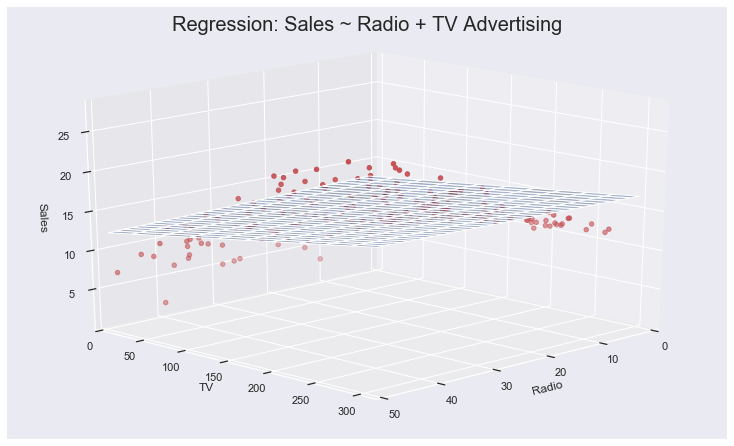

In [95]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');
ax.view_init(20, 45)


The positive residuals (those visible above the surface), tend to lie along the 45-degree line, where TV and Radio budgets are split evenly. The negative residuals (most not visible), tend to lie away from this line, where budgets are more lopsided.

It suggests a synergy or interaction effect between the advertising media, whereby combining the media together results in a bigger boost to sales than using any single medium

## 3.3 Other Considerations in the Regression Model

### Figure 3.6

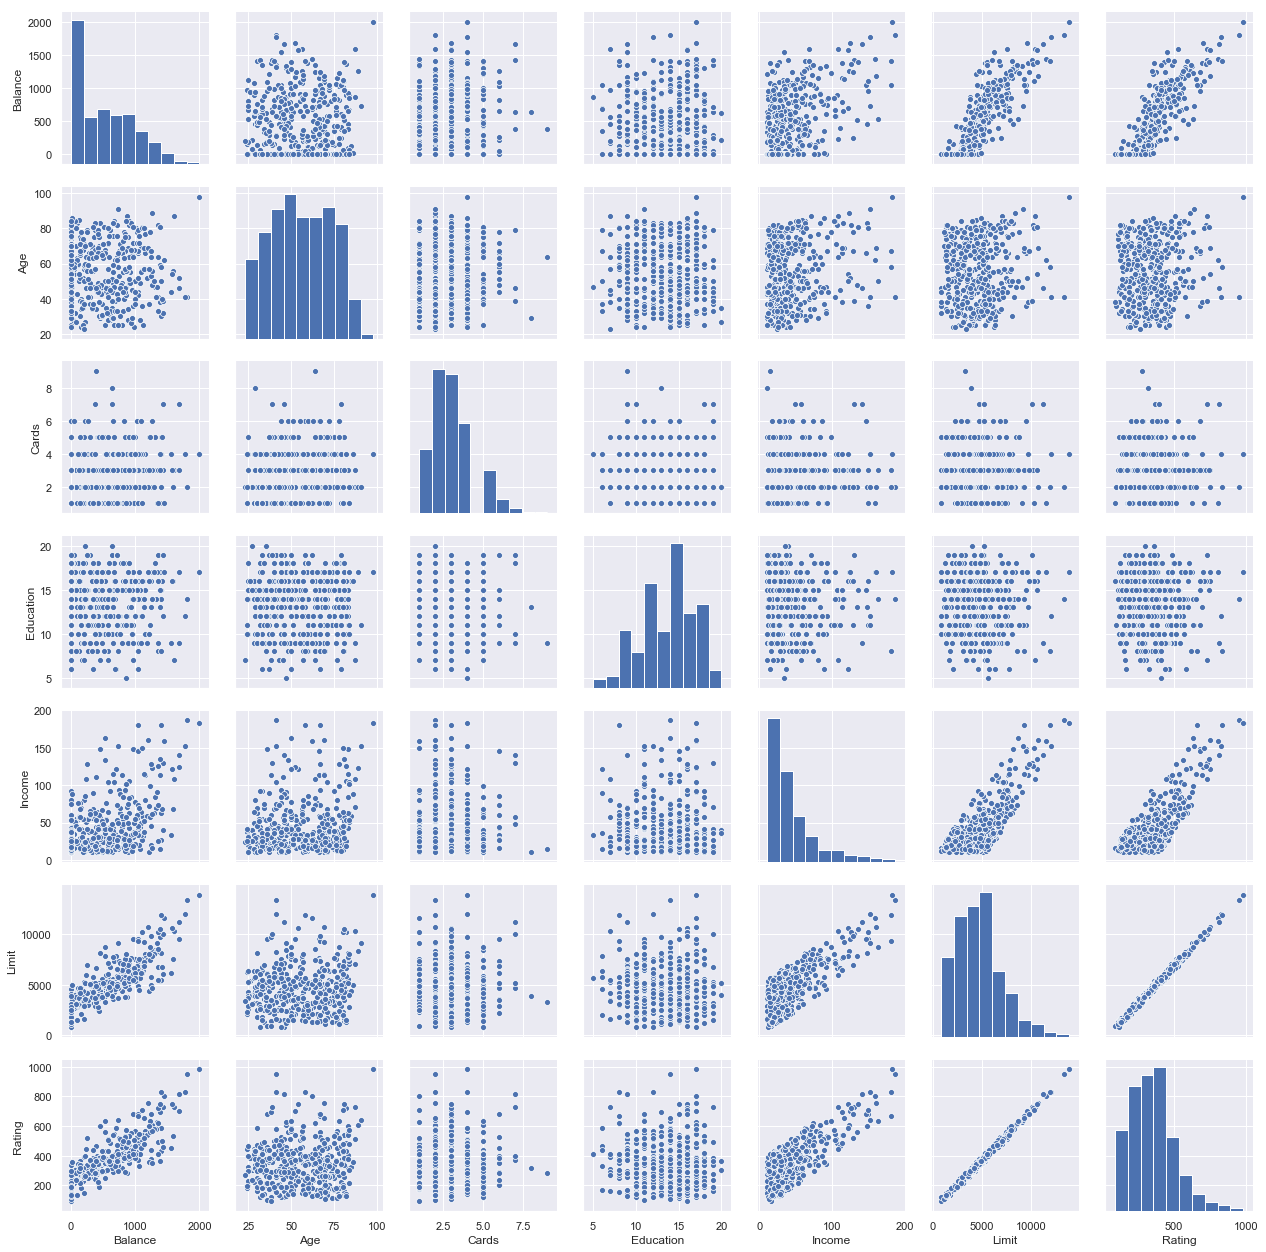

In [96]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

###  Table 3.7 - regress Balance on Gender
High p-value suggesting null hypothesis cannot be rejected, i.e. there is no relationship between Balance and Female

In [97]:
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


### Table 3.8 - regress Balance on Ethnicity

High p-value suggesting null hypothesis cannot be rejected, i.e. there is no relationship between Balance and Ethnicity

In [98]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### F-Statistic - regress Balance on Ethnicity

This F-test has a p-value of 0.96, indicating that we cannot reject the null
hypothesis that there is no relationship between balance and ethnicity

In [100]:
est.summary().tables[0]

Dep. Variable:,Balance,R-squared:,0.000
Model:,OLS,Adj. R-squared:,-0.005
Method:,Least Squares,F-statistic:,0.04344
Date:,"Tue, 26 Nov 2019",Prob (F-statistic):,0.957
Time:,00:05:01,Log-Likelihood:,-3019.3
No. Observations:,400,AIC:,6045.
Df Residuals:,397,BIC:,6057.
Df Model:,2,,
Covariance Type:,nonrobust,,


### Interaction Variables

- In the prediction plot involving Radio and TV, we observe that the model tends to underestimate the sales increase when the budget is split equally between Radio and TV. This strongly suggest that there are synergistic effects that are not accounted for in the linear model 

#### Examining p-value/coefficient value

- The p-value for the interaction term, TV×radio, is extremely low, indicating that there is strong evidence for Ha : β3 != 0. In other words, it is clear that the true relationship is not additive.

- Interpretation of 'coef' of TV/Radio - suggest that an increase in TV advertising of 1,000 is associated with increased sales of (β1+ β3 ×radio)×1,000 = 19+1.1×radio units. And an increase in radio advertising of $1,000 will be associated with an increase in sales of ( ˆ β2 + ˆ β3 × TV) × 1,000 = 29 + 1.1 × TV units.


In [102]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


#### Examining R2

- The R2 for the model (3.33) is 96.8%, compared to only 89.7% for the model that predicts sales using TV and radio without an interaction term. This means that (96.8 − 89.7)/(100 − 89.7) = 69% of the variability in sales that remains after fitting the additive model has been explained by the interaction term.

In [118]:
est = smf.ols('Sales ~ TV + Radio', advertising).fit()
est.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,859.6
Date:,"Tue, 26 Nov 2019",Prob (F-statistic):,4.83e-98
Time:,00:53:35,Log-Likelihood:,-386.20
No. Observations:,200,AIC:,778.4
Df Residuals:,197,BIC:,788.3
Df Model:,2,,
Covariance Type:,nonrobust,,


In [119]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.968
Model:,OLS,Adj. R-squared:,0.967
Method:,Least Squares,F-statistic:,1963.
Date:,"Tue, 26 Nov 2019",Prob (F-statistic):,6.68e-146
Time:,00:53:37,Log-Likelihood:,-270.14
No. Observations:,200,AIC:,548.3
Df Residuals:,196,BIC:,561.5
Df Model:,3,,
Covariance Type:,nonrobust,,


### Figure 3.7 - Interaction between qualitative and quantative variables

In [108]:
credit['Student2'] = credit['Student'].map({'No':0, 'Yes':1})

In [109]:
# See pg 89 for the equation seperating student/non-student
est1 = smf.ols('Balance ~ Income + Student2', credit).fit() # Without interaction
regr1 = est1.params # This is a pd.Series
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit() # With interaction
regr2 = est2.params # This is a pd.Series

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


D:\Anaconda\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


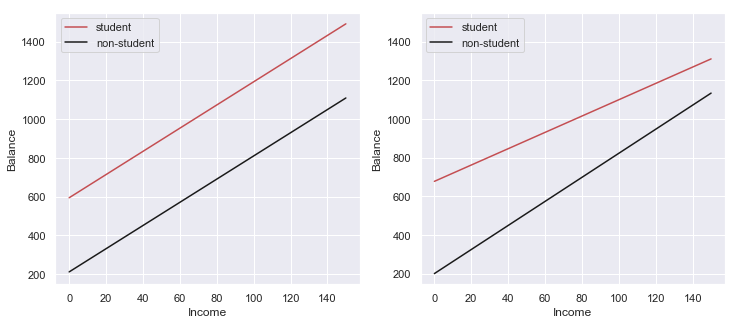

In [110]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
# 
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])

non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

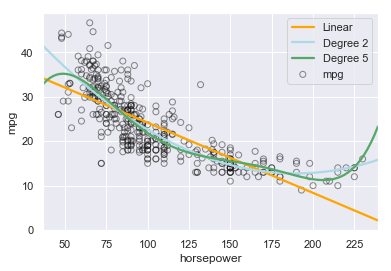

In [125]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto['horsepower'],
            auto['mpg'],
            facecolors='None', # To plot empty circles
            edgecolors='k',
            alpha=.5)
sns.regplot(auto['horsepower'],
            auto['mpg'],
            ci=None, # Size of the confidence interval 
            label='Linear',
            order=1, # Specify polynomial 
            scatter=False, 
            color='orange')
sns.regplot(auto['horsepower'],
            auto['mpg'],
            ci=None,
            label='Degree 2',
            order=2,
            scatter=False,
            color='lightblue')
sns.regplot(auto['horsepower'],
            auto['mpg'],
            ci=None,
            label='Degree 5',
            order=5,
            scatter=False,
            color='g')
plt.legend()

### Table 3.10

In [128]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower**2,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0,22500.0


In [131]:
est = smf.ols('mpg ~ horsepower', auto).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           7.03e-81
Time:                        01:13:15   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 of the quadratic fit is 0.688, compared to 0.606 for the linear fit, and the p-value in Table 3.10 for the quadratic term is highly significant.

In [132]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           5.40e-99
Time:                        01:13:25   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      56.9001      1.800     31.604      0.000      53.360      60.440
horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Figure 3.9

In [142]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto['horsepower'].values.reshape(-1,1)
y = auto['mpg']
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto['mpg'] - auto['pred1']

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']]
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto['mpg'] - auto['pred2']

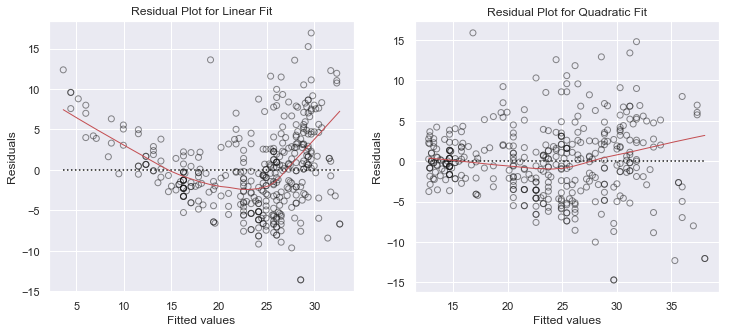

In [143]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto['pred1'], auto['resid1'], lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto['pred2'], auto['resid2'], lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

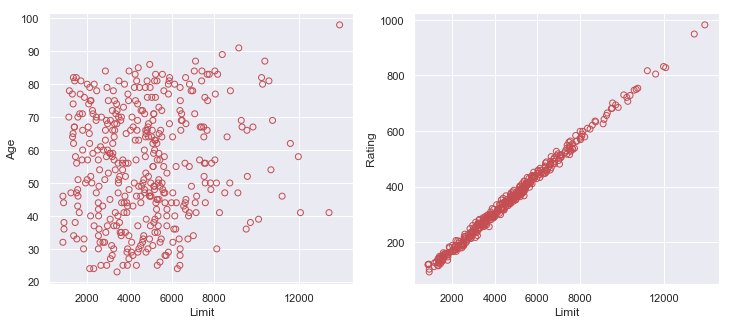

In [144]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit['Limit'], credit['Age'], facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit['Limit'], credit['Rating'], facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [145]:
y = credit['Balance']

# Regression for left plot
X = credit[['Age', 'Limit']]
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']]
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


In [146]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

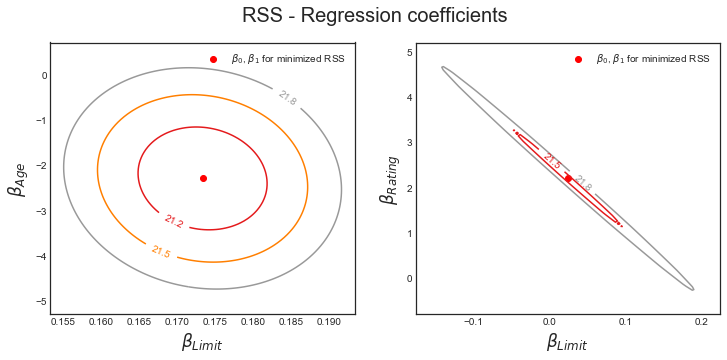

In [37]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Variance Inflation Factor - page 102

In [147]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.0113846860681328
160.66830095856935
160.59287978597942
